# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.head(85)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [7]:
feat_info.shape

(85, 4)

In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
feat_info.isnull().count()

attribute             85
information_level     85
type                  85
missing_or_unknown    85
dtype: int64

In [10]:
feat_info.head(20)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [12]:
for att in feat_info['attribute']:

    temp_list = feat_info[feat_info['attribute']==att].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
    missing_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in temp_list]
    #lstrip is to cut the '-' sign in the string
    #isnumeric checks whether it is number or not
    
    azdias[att].replace(to_replace=missing_unknown_list,
                      value=np.nan, inplace=True)

In [13]:
azdias.sample(20)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
358133,NaN,3.0,1,3.0,1,5,3,5,4,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,4.0,4.0
46476,NaN,1.0,1,6.0,1,5,2,5,4,5,...,1.0,4.0,2.0,2.0,4.0,3.0,2.0,5.0,5.0,5.0
669127,NaN,3.0,2,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617047,NaN,2.0,2,3.0,3,5,1,5,5,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745176,NaN,3.0,2,NaN,1,4,3,5,4,5,...,3.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,1.0
608442,NaN,1.0,1,6.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702429,NaN,3.0,1,4.0,3,3,3,4,1,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,5.0,5.0,5.0
201437,NaN,3.0,2,4.0,5,2,4,3,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,2.0,5.0,2.0
368353,NaN,1.0,1,3.0,4,5,2,3,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,4.0
772018,NaN,3.0,1,4.0,2,5,1,5,3,3,...,1.0,4.0,3.0,2.0,4.0,3.0,2.0,5.0,4.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum().sort_values(ascending=False)


TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

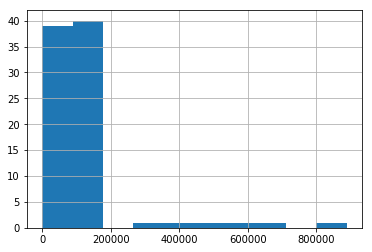

In [15]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().hist()


In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_col = list(azdias.isnull().sum()[azdias.isnull().sum()>200000].index)
azdias_new = azdias.copy() #create copy of dataset 
azdias_new.drop(drop_col, axis='columns', inplace=True)

In [17]:
azdias_new.isnull().sum().sort_values(ascending=False)

KKK                      158064
REGIOTYP                 158064
W_KEIT_KIND_HH           147988
MOBI_REGIO               133324
KBA05_ANTG4              133324
KBA05_ANTG3              133324
KBA05_ANTG2              133324
KBA05_ANTG1              133324
KBA05_GBZ                133324
PLZ8_ANTG2               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG4               116515
PLZ8_BAUMAX              116515
PLZ8_HHZ                 116515
PLZ8_GBZ                 116515
HEALTH_TYP               111196
SHOPPER_TYP              111196
VERS_TYP                 111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DEUG_2015           99352
LP_LEBENSPHASE_FEIN       97632
RELAT_AB                  97375
ARBEIT                    97375
ORTSGR_KLS9               97274
                          ...  
GFK_URLA

#### Discussion 1.1.2: Assess Missing Data in Each Column

During analysis of these two datasets, it was noted that missing and unknown values within the feature dataset were in a format that would be incongruent with data analysis. Therefore, these values were changed to null or NaN values. Additionally, there were several null values noted within the azdias dataset. Upon viewing these null values via a histogram, it was noted that certain columns had significantly more null values compared to other columns. It was determined these column values with significantly high null values, identified as columns 'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR' and 'ALTER_HH', were outliers and were then removed from the azdias dataset. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

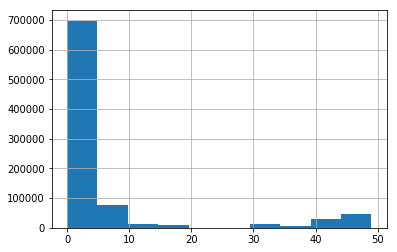

In [18]:
# How much data is missing in each row of the dataset?
azdias_new.isnull().sum(axis=1).sort_values(ascending=False).hist()


In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_lownull = azdias_new.drop(azdias[azdias.isnull().sum(axis=1) > 25].index)
azdias_highnull = azdias_new.drop(azdias[azdias.isnull().sum(axis=1) <= 25].index)


In [20]:
azdias_lownull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797384 entries, 1 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     794599 non-null float64
ANREDE_KZ                797384 non-null int64
CJT_GESAMTTYP            792744 non-null float64
FINANZ_MINIMALIST        797384 non-null int64
FINANZ_SPARER            797384 non-null int64
FINANZ_VORSORGER         797384 non-null int64
FINANZ_ANLEGER           797384 non-null int64
FINANZ_UNAUFFAELLIGER    797384 non-null int64
FINANZ_HAUSBAUER         797384 non-null int64
FINANZTYP                797384 non-null int64
GFK_URLAUBERTYP          792744 non-null float64
GREEN_AVANTGARDE         797384 non-null int64
HEALTH_TYP               760957 non-null float64
LP_LEBENSPHASE_FEIN      747722 non-null float64
LP_LEBENSPHASE_GROB      750538 non-null float64
LP_FAMILIE_FEIN          766251 non-null float64
LP_FAMILIE_GROB          766251 non-null float64
LP_STATUS_FEIN           792744 non-null float64
LP_STATUS_GROB           

In [21]:
azdias_highnull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93837 entries, 0 to 891187
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     93741 non-null float64
ANREDE_KZ                93837 non-null int64
CJT_GESAMTTYP            93623 non-null float64
FINANZ_MINIMALIST        93837 non-null int64
FINANZ_SPARER            93837 non-null int64
FINANZ_VORSORGER         93837 non-null int64
FINANZ_ANLEGER           93837 non-null int64
FINANZ_UNAUFFAELLIGER    93837 non-null int64
FINANZ_HAUSBAUER         93837 non-null int64
FINANZTYP                93837 non-null int64
GFK_URLAUBERTYP          93623 non-null float64
GREEN_AVANTGARDE         93837 non-null int64
HEALTH_TYP               19068 non-null float64
LP_LEBENSPHASE_FEIN      45867 non-null float64
LP_LEBENSPHASE_GROB      46111 non-null float64
LP_FAMILIE_FEIN          47178 non-null float64
LP_FAMILIE_GROB          47178 non-null float64
LP_STATUS_FEIN           93623 non-null float64
LP_STATUS_GROB           93623 non-null floa

In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

azdias_lownull.isnull().sum()[azdias_lownull.isnull().sum()==0]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
SOHO_KZ                  0
ZABEOTYP                 0
ANZ_PERSONEN             0
ANZ_TITEL                0
HH_EINKOMMEN_SCORE       0
WOHNDAUER_2008           0
GEBAEUDETYP              0
MIN_GEBAEUDEJAHR         0
OST_WEST_KZ              0
WOHNLAGE                 0
dtype: int64

In [23]:
azdias_highnull.isnull().sum()[azdias_highnull.isnull().sum()==0]

ANREDE_KZ                0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GREEN_AVANTGARDE         0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
SEMIO_ERL                0
SEMIO_KULT               0
SEMIO_RAT                0
SEMIO_KRIT               0
SEMIO_DOM                0
SEMIO_KAEM               0
SEMIO_PFLICHT            0
SEMIO_TRADV              0
ZABEOTYP                 0
dtype: int64

In [24]:
# Function to compare columns of null values from both dfs
def compare_plot(col):
    ''' 
    Input: Column name from dfs to use for comparison
    Output: Plots of columns from above/below threshold
    '''
    
    ax1 = plt.subplot(1,2,1)
    sns.countplot(azdias_lownull[col], ax=ax1)
    plt.title('Least Missing Values')
    ax2 = plt.subplot(1,2,2)
    sns.countplot(azdias_highnull[col], ax=ax2)
    plt.title('Most Missing Values')
    
    

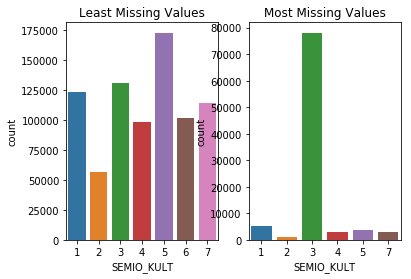

In [25]:
# Use the barchart to compare 5 columns between the 2 datasets
#Calling Function with 1 column
compare_plot('SEMIO_KULT')

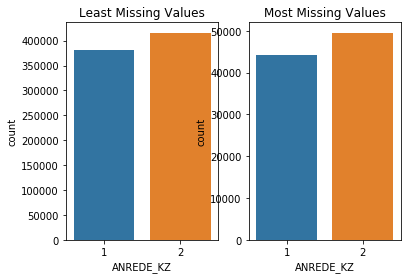

In [26]:
#Second time calling function
compare_plot('ANREDE_KZ')

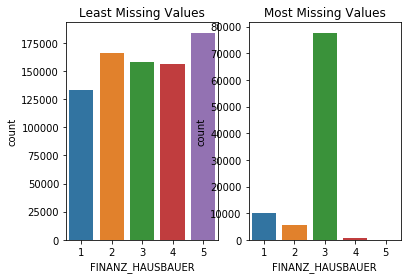

In [27]:
#Third time calling function
compare_plot('FINANZ_HAUSBAUER')

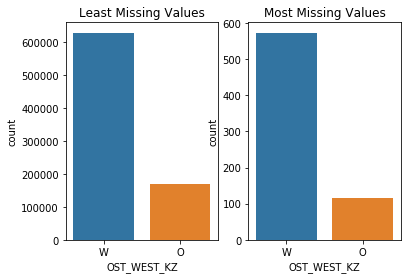

In [28]:
#Fourth time calling function
compare_plot('OST_WEST_KZ')

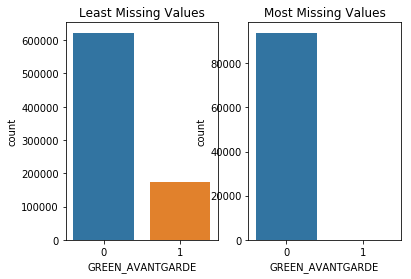

In [29]:
#Fifth time calling function
compare_plot('GREEN_AVANTGARDE')

#### Discussion 1.1.3: Assess Missing Data in Each Row

After comparing data from multiple columns between two different datasets, above and below the threshold of missing values, it appears the dataset below the threshold of null values has more variability than the dataset with higher numbers of null values. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?
feat_info.groupby(by='type').count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Showing categorical values in full dataset
for att in feat_info[feat_info['type']=='categorical'].attribute:
    if att in azdias_new.columns:
        print(att, azdias_new[att].nunique())


ANREDE_KZ 2
CJT_GESAMTTYP 6
FINANZTYP 6
GFK_URLAUBERTYP 12
GREEN_AVANTGARDE 2
LP_FAMILIE_FEIN 11
LP_FAMILIE_GROB 5
LP_STATUS_FEIN 10
LP_STATUS_GROB 5
NATIONALITAET_KZ 3
SHOPPER_TYP 4
SOHO_KZ 2
VERS_TYP 2
ZABEOTYP 6
GEBAEUDETYP 7
OST_WEST_KZ 2
CAMEO_DEUG_2015 9
CAMEO_DEU_2015 44


In [32]:
# Determining which categorical cols are binary in azdias_lownull df
for att in feat_info[feat_info['type']=='categorical'].attribute:
    if att in azdias_lownull.columns:
        if azdias_lownull[att].nunique() == 2:
            print(att, azdias_lownull[att].unique())

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
OST_WEST_KZ ['W' 'O']


In [33]:
#Looking ahead to cleaning function for future dfs - drop_col makes easier
drop_col

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [34]:
#Determining which categorical cols are multi-level in azdias_lownull df

for att in feat_info[feat_info['type']=='categorical'].attribute:
    if att in azdias_lownull.columns:
        if azdias_lownull[att].nunique() > 2:
            #putting multi-level categorical cols into list
            drop_col.append(att)
            azdias_lownull.drop(att, axis=1, inplace=True)
print(drop_col)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [35]:
#Checking under_25 df rows/cols
azdias_lownull.shape

(797384, 66)

In [36]:
# Identify binary category column with non-numerical values
azdias_lownull['OST_WEST_KZ'].unique()


array(['W', 'O'], dtype=object)

In [37]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_lownull = pd.get_dummies(azdias_lownull, columns=['OST_WEST_KZ'])

In [38]:
#Viewing df
azdias_lownull.shape

(797384, 67)

#### Discussion 1.2.1: Re-Encode Categorical Features

Upon viewing the categorical columns within the dataset containing the least missing values, it was determined several contained muli-level values. These columns were deemed unnecessary for this project and were removed. Columns containing categorical binary values were retained. One column, 'OST_WEST_KZ', was found to contain non-numeric values and was converted to numeric values via the use of dummy variables.

Categorical Columns Retained: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP, and OST_WEST_KZ.

Categorical Columns Removed: CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, and CAMEO_DEU_2015

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
#Reading 'Data_Dictionary.md'
file = open('Data_Dictionary.md').read()
print(file)

# Data Dictionary for Identify Customer Segments Data

## Introduction

The data for this project consist of two files:

- Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
- Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)

The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.

### Table of Contents

 1. Person-level features
 2. Household-level features
 3. Building-level features
 4. RR4 micro-cell features
 5. RR3 micro-cell features
 6. Postcode-level fe

In [40]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Viewing values from "PRAEGENDE_JUGENDJAHRE"
azdias_lownull['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [41]:
#Creating dict to hold values from 'Data_Dictionary.md'
PJ_dict = {
    1: [40,0],
    2: [40,1],
    3: [50,0],
    4: [50,1],
    5: [60,0],
    6: [60,1],
    7: [60,1],
    8: [70,0],
    9: [70,1],
    10: [80,0],
    11: [80,1],
    12: [80,0],
    13: [80,1],
    14: [90,0],
    15: [90,1],
    np.nan: [np.nan, np.nan]
}
# 0 is Mainstream, 1 is Avantgarde

PJ_dict[1]

[40, 0]

In [42]:
#Creating columns for "Generation" and "Movement" based on values in col and dict
azdias_lownull['GENERATION'] = azdias_lownull['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else PJ_dict[x][0])
azdias_lownull['MOVEMENT'] = azdias_lownull['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else PJ_dict[x][1])

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
#"CAMEO_INTL_2015" combines information on two axes: wealth and life stage.
#Break up the two-digit codes by their 'tens'-place and 'ones'-place digits
#into two new ordinal variables

azdias_lownull['WEALTH'] = azdias_lownull['CAMEO_INTL_2015'].str[0]
azdias_lownull['LIFE_STAGE'] = azdias_lownull['CAMEO_INTL_2015'].str[1]


In [44]:
#Removing original columns from df
for col in drop_col:
    if col in azdias_lownull:
        azdias_lownull.drop(drop_col, axis=1, inplace=True)
        
azdias_lownull.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
azdias_lownull.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [45]:
#Viewing df
azdias_lownull.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797384 entries, 1 to 891220
Data columns (total 69 columns):
ALTERSKATEGORIE_GROB     794599 non-null float64
ANREDE_KZ                797384 non-null int64
FINANZ_MINIMALIST        797384 non-null int64
FINANZ_SPARER            797384 non-null int64
FINANZ_VORSORGER         797384 non-null int64
FINANZ_ANLEGER           797384 non-null int64
FINANZ_UNAUFFAELLIGER    797384 non-null int64
FINANZ_HAUSBAUER         797384 non-null int64
GREEN_AVANTGARDE         797384 non-null int64
HEALTH_TYP               760957 non-null float64
LP_LEBENSPHASE_FEIN      747722 non-null float64
LP_LEBENSPHASE_GROB      750538 non-null float64
RETOURTYP_BK_S           792744 non-null float64
SEMIO_SOZ                797384 non-null int64
SEMIO_FAM                797384 non-null int64
SEMIO_REL                797384 non-null int64
SEMIO_MAT                797384 non-null int64
SEMIO_VERT               797384 non-null int64
SEMIO_LUST               797384 n

In [46]:
#Identify 'mixed' type features
#putting mixed cols into appointed lists for future cleaning function
keep_col = []
for att in feat_info[feat_info['type']=='mixed'].attribute:
    if (att == 'PRAEGENDE_JUGENDJAHRE') or (att == 'CAMEO_INTL_2015'):
        keep_col.append(att)
    else:
        drop_col.append(att)
print(drop_col)
print(keep_col)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX']
['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']


In [47]:
print(len(drop_col))

24


#### Discussion 1.2.2: Engineer Mixed-Type Features

When assessing the mixed-type features, it was determined two columns contained values that also had additional features. These columns were further dissected into their own columns for the purpose of analysis. The remaining mixed-type features were removed.

Columns Dissected: 
    PRAEGENDE_JUGENDJAHRE was dissected into GENERATION and MOVEMENT
    CAMEO_INTL_2015 was dissected into WEALTH and LIFE_STYLE
    
Columns Removed: 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [48]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.




### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for att in feat_info['attribute']:
        temp_list = feat_info[feat_info['attribute']==att].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
        missing_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in temp_list]
        df[att].replace(to_replace=missing_unknown_list,
                      value=np.nan, inplace=True)
        
    for att in feat_info[feat_info['type']=='categorical'].attribute:
        if att in df.columns:
            if df[att].nunique() > 2:
            #putting multi-level categorical cols into list
                drop_col.append(att)
                
    
    # remove selected columns and rows, ...
    keep_col = []
    for att in feat_info[feat_info['type']=='mixed'].attribute:
        if (att == 'PRAEGENDE_JUGENDJAHRE') or (att == 'CAMEO_INTL_2015'):
            keep_col.append(att)
        else:
            drop_col.append(att)
            
    df.drop(drop_col, axis=1, inplace=True)
    
    # select, re-encode, and engineer column values.
    df = pd.get_dummies(df, columns=['OST_WEST_KZ'])

    df['GENERATION'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else PJ_dict[x][0])
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: np.nan if np.isnan(x) else PJ_dict[x][1])

    df['WEALTH'] = df['CAMEO_INTL_2015'].str[0]
    df['LIFE_STYLE'] = df['CAMEO_INTL_2015'].str[1]
    
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    azdias_lownull = df.drop(df[df.isnull().sum(axis=1)>25].index)
    azdias_highnull = df.drop(df[df.isnull().sum(axis=1)<=25].index)
    
    # Return the cleaned dataframe.
    return azdias_lownull
    

In [51]:
#Test cleaning function
azdias_clean = clean_data(azdias)

In [52]:
#Viewing df
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798073 entries, 1 to 891220
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB     795270 non-null float64
ANREDE_KZ                798073 non-null int64
FINANZ_MINIMALIST        798073 non-null int64
FINANZ_SPARER            798073 non-null int64
FINANZ_VORSORGER         798073 non-null int64
FINANZ_ANLEGER           798073 non-null int64
FINANZ_UNAUFFAELLIGER    798073 non-null int64
FINANZ_HAUSBAUER         798073 non-null int64
GREEN_AVANTGARDE         798073 non-null int64
HEALTH_TYP               761341 non-null float64
RETOURTYP_BK_S           793319 non-null float64
SEMIO_SOZ                798073 non-null int64
SEMIO_FAM                798073 non-null int64
SEMIO_REL                798073 non-null int64
SEMIO_MAT                798073 non-null int64
SEMIO_VERT               798073 non-null int64
SEMIO_LUST               798073 non-null int64
SEMIO_ERL                798073 non-null int64
SEMIO_KULT               798073 non-n

In [53]:
#Checking for remaining null values after cleaning
azdias_clean.isna().any().values

array([ True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True], dtype=bool)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [54]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imp = Imputer()
clean_azdias = imp.fit_transform(azdias_clean)



In [55]:
#Verifying no null vals
np.isnan(clean_azdias).any()

False

In [56]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns=azdias_clean.columns)
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(clean_azdias)


In [57]:
#Converting to df
scaled_azdias = pd.DataFrame(azdias_scaled, columns=azdias_clean.columns)

In [58]:
#Viewing df
scaled_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,GENERATION,MOVEMENT,WEALTH,LIFE_STYLE
0,-1.766074,0.957905,-1.494591,1.537913,-1.040677,1.465948,0.958614,1.339325,-0.530404,1.085953,...,0.565113,-0.167284,-0.127704,0.684613,-0.517429,0.517429,1.165689,-0.553153,1.191332,-1.266430
1,0.201243,0.957905,-1.494591,0.864553,-1.766962,-0.571007,0.244095,1.339325,1.885354,1.085953,...,0.565113,-0.167284,-0.127704,-0.789309,-0.517429,0.517429,1.165689,1.875412,-0.865168,0.761985
2,1.184901,0.957905,0.683151,-0.482167,1.138179,-0.571007,-1.184943,-0.791195,-0.530404,-0.269821,...,0.565113,-1.170875,-0.998247,-0.052348,-0.517429,0.517429,-0.232027,-0.553153,-1.550667,-0.590291
3,0.201243,-1.043944,0.683151,0.191193,0.411893,-1.249992,0.244095,-0.791195,-0.530404,1.085953,...,-0.347960,0.836306,0.307568,1.421574,-0.517429,0.517429,-0.232027,-0.553153,0.505832,0.085847
4,-1.766074,0.957905,-0.042763,-1.155526,1.138179,-0.571007,-0.470424,1.339325,-0.530404,1.085953,...,1.478186,-1.170875,-0.998247,-0.052348,-0.517429,0.517429,-1.629742,-0.553153,1.191332,0.761985


In [59]:
#Exploring df
scaled_azdias.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,GENERATION,MOVEMENT,WEALTH,LIFE_STYLE
count,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,...,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05,7.980730e+05
mean,9.883654e-16,-1.206655e-16,2.438595e-17,1.018173e-16,1.332012e-16,-1.273607e-16,-2.606866e-17,8.556004e-17,-1.528685e-17,1.836549e-15,...,-4.477078e-16,1.395599e-15,-2.260530e-16,9.537140e-17,-1.004284e-17,-1.496099e-16,-5.472993e-16,2.295520e-16,-3.859194e-16,1.991118e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766074e+00,-1.043944e+00,-1.494591e+00,-1.155526e+00,-1.766962e+00,-1.249992e+00,-1.184943e+00,-1.501369e+00,-5.304043e-01,-1.625594e+00,...,-2.174106e+00,-2.174466e+00,-1.868791e+00,-1.526271e+00,-5.174286e-01,-1.932634e+00,-2.328600e+00,-5.531527e-01,-1.550667e+00,-1.266430e+00
25%,-7.824156e-01,-1.043944e+00,-7.686772e-01,-1.155526e+00,-1.040677e+00,-1.249992e+00,-1.184943e+00,-7.911953e-01,-5.304043e-01,-2.698206e-01,...,-3.479598e-01,-1.672845e-01,-5.629755e-01,-7.893094e-01,-5.174286e-01,5.174286e-01,-9.308845e-01,-5.531527e-01,-8.651676e-01,-1.266430e+00
50%,2.012425e-01,9.579054e-01,-4.276316e-02,1.911931e-01,4.118935e-01,1.079777e-01,-4.704239e-01,-8.102179e-02,-5.304043e-01,-2.698206e-01,...,-3.479598e-01,-1.672845e-01,-1.277038e-01,-5.234831e-02,-5.174286e-01,5.174286e-01,-9.931367e-16,-5.531527e-01,5.058318e-01,8.584706e-02
75%,1.184901e+00,9.579054e-01,6.831508e-01,8.645528e-01,1.138179e+00,7.869626e-01,9.586142e-01,6.291518e-01,-5.304043e-01,1.085953e+00,...,5.651132e-01,8.363061e-01,7.428398e-01,6.846128e-01,-5.174286e-01,5.174286e-01,1.165689e+00,2.022187e-16,1.191332e+00,7.619854e-01
max,1.184901e+00,9.579054e-01,1.409065e+00,1.537913e+00,1.138179e+00,1.465948e+00,1.673133e+00,1.339325e+00,1.885354e+00,1.085953e+00,...,1.478186e+00,1.839897e+00,1.613383e+00,1.421574e+00,1.932634e+00,5.174286e-01,1.165689e+00,1.875412e+00,1.191332e+00,1.438124e+00


In [60]:
#Viewing df
scaled_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798073 entries, 0 to 798072
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB     798073 non-null float64
ANREDE_KZ                798073 non-null float64
FINANZ_MINIMALIST        798073 non-null float64
FINANZ_SPARER            798073 non-null float64
FINANZ_VORSORGER         798073 non-null float64
FINANZ_ANLEGER           798073 non-null float64
FINANZ_UNAUFFAELLIGER    798073 non-null float64
FINANZ_HAUSBAUER         798073 non-null float64
GREEN_AVANTGARDE         798073 non-null float64
HEALTH_TYP               798073 non-null float64
RETOURTYP_BK_S           798073 non-null float64
SEMIO_SOZ                798073 non-null float64
SEMIO_FAM                798073 non-null float64
SEMIO_REL                798073 non-null float64
SEMIO_MAT                798073 non-null float64
SEMIO_VERT               798073 non-null float64
SEMIO_LUST               798073 non-null float64
SEMIO_ERL                798073 non-null float64
SEMIO_K

### Discussion 2.1: Apply Feature Scaling

After cleaning the dataset, the Imputer function was used to remove any remaining null values. After verifying all null values were removed, the StandardScaler function was applied to scale each feature to a mean of 0 and standard deviation of 1. This places each feature on a standardized scale for analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [61]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA()
pca_azdias = pca.fit_transform(azdias_scaled)


In [62]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca, num_components=None):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instance of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    if num_components == None:
        num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


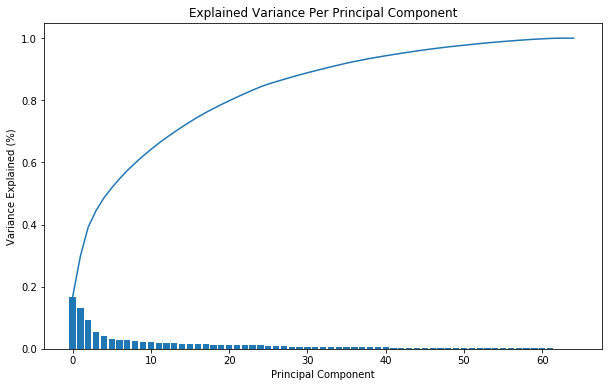

In [63]:
#Calling function to plot
scree_plot(pca)

In [64]:
# How much variance in the original data is explained when increasing number of components
for i in np.arange(10, len(pca.explained_variance_ratio_), 20):
    print('{} components explains {}% of variance'.format(i,(pca.explained_variance_ratio_[:i].sum()) * 100))

10 components explains 62.083268600713915% of variance
30 components explains 88.1865180330393% of variance
50 components explains 97.46961236439908% of variance


In [65]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=35)
pca_fit = pca.fit(azdias_scaled)
azdias_pca = pca.transform(azdias_scaled)


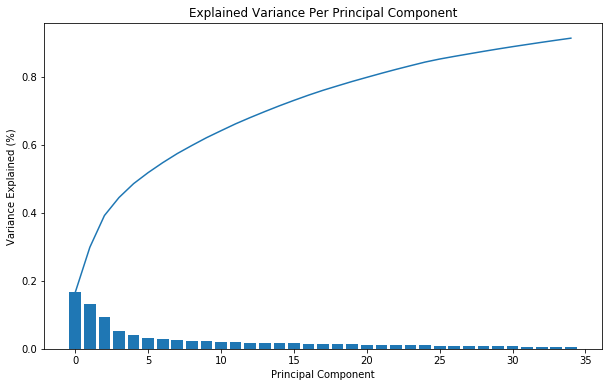

In [66]:
# Plotting for the specific number of components
scree_plot(pca,num_components=35)

### Discussion 2.2: Perform Dimensionality Reduction

According to the Pricipal Component Analysis (PCA), 10 components can explain 62% of the variance, while 30 components can explain 88% of the variance. I chose to retain 35 components as this explains over 90% of the variance and should lead to increased accuracy for unsupervised machine learning models.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weight(df, component):
    pca_df = pd.DataFrame(pca.components_, columns=list(df.columns))
    pca_component = pd.DataFrame(pca_df.iloc[component])
    pca_component.sort_values(component, ascending=False, inplace=True)
    # Capturing most interesting features which at the end and beginning of sorted list
    pca_component = pd.concat([pca_component.head(), pca_component.tail()])
    
    pca_component.plot(kind='bar', 
                  title='Weighted features for PCA component {}'.format(component),
                  figsize=(12, 6));
    plt.show()
    
    print(pca_component.head(), pca_component.tail())
 

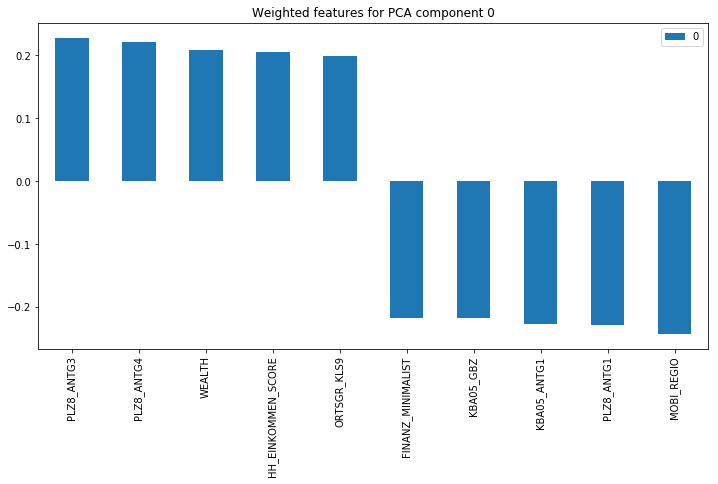

                           0
PLZ8_ANTG3          0.227854
PLZ8_ANTG4          0.221348
WEALTH              0.208355
HH_EINKOMMEN_SCORE  0.204412
ORTSGR_KLS9         0.197998                           0
FINANZ_MINIMALIST -0.217145
KBA05_GBZ         -0.217966
KBA05_ANTG1       -0.226834
PLZ8_ANTG1        -0.228129
MOBI_REGIO        -0.242925


In [68]:
#Map weights for first primary component
map_weight(scaled_azdias, 0)

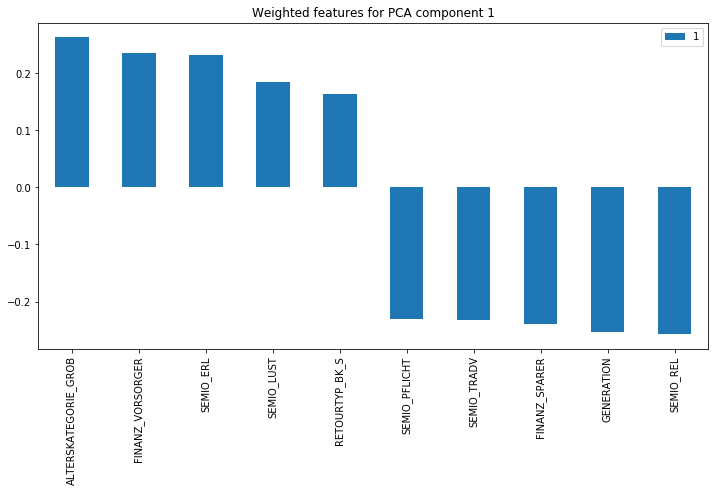

                             1
ALTERSKATEGORIE_GROB  0.262306
FINANZ_VORSORGER      0.234573
SEMIO_ERL             0.231437
SEMIO_LUST            0.184865
RETOURTYP_BK_S        0.163730                       1
SEMIO_PFLICHT -0.230141
SEMIO_TRADV   -0.232963
FINANZ_SPARER -0.238796
GENERATION    -0.253329
SEMIO_REL     -0.256411


In [69]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(scaled_azdias, 1)

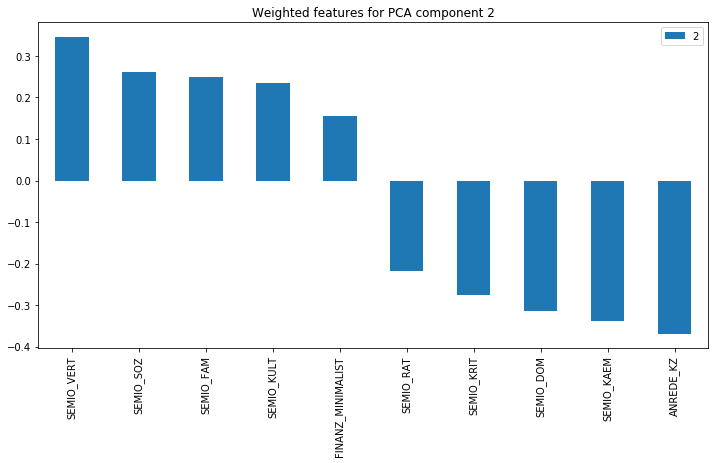

                          2
SEMIO_VERT         0.345504
SEMIO_SOZ          0.262575
SEMIO_FAM          0.250149
SEMIO_KULT         0.235799
FINANZ_MINIMALIST  0.156358                    2
SEMIO_RAT  -0.217500
SEMIO_KRIT -0.276502
SEMIO_DOM  -0.314708
SEMIO_KAEM -0.337515
ANREDE_KZ  -0.368831


In [70]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weight(scaled_azdias, 2)

### Discussion 2.3: Interpret Principal Components

Comparing weighted components can indicate a correlational relationship between components. When both features have positive values, it suggests a positive correlation between the two components. When one value increases, the other will also increase. Features that have negative values suggest a negative correlation with the feature component of comparison. As one feature value increases, the other decreases. 

The first graph compares the feature components against the first component with the largest amount of variance. The five features with the largest positive values and the five features with the largest negative values are listed below.

1. **PLZ8_ANTG3** - Number of 6-10 family houses in the PLZ8 region
2. **PLZ8_ANTG4** - Number of 10+ family houses in the PLZ8 region
3. **WEALTH** - Financial classification of household (Wealthy, Prosperous, Comfortable, Less Affluent, Poorer)           
4. **HH_EINKOMMEN_SCORE** - Estimated household net income
5. **ORTSGR_KLS9** - Size of Community                 
6. **FINANZ_MINIMALIST** - Financial Typology: low financial interest
7. **KBA05_GBZ** - Number of buildings in the microcell
8. **KBA05_ANTG1** - Number of 1-2 family houses in the microcell
9. **PLZ8_ANTG1** - Number of 1-2 family houses in the PLZ8 region
10. **MOBI_REGIO** - Movement patterns

The second graph compares the feature components against the second component with the largest amount of variance. The five features with the largest positive values and the five features with the largest negative values are listed below.

1. **ALTERSKATEGORIE_GROB** - Estimated age based on given name analysis
2. **FINANZ_VORSORGER** - Financial typology, be prepared
3. **SEMIO_ERL** - Personality typology, event-oriented
4. **SEMIO_LUST** - Personality typology, sensual-minded
5. **RETOURTYP_BK_S** - Return type, based on personality of shopper           

6. **SEMIO_PFLICHT** - Personality typology, dutiful
7. **SEMIO_TRADV** - Personality typology, tradional-minded
8. **FINANZ_SPARER** - Financial typology, money-saver
9. **GENERATION** - Generation/Time Period shopper grew up in
10. **SEMIO_REL** - Personality typology, religious

The third graph compares the feature components against the third component with the largest amount of variance. The five features with the largest positive values and the five features with the largest negative values are listed below.

1. **SEMIO_VERT** - Personality typology, dreamful
2. **SEMIO_SOZ** - Personality typology, socially-minded
3. **SEMIO_FAM** - Personality typology, family-minded
4. **SEMIO_KULT** - Personality typology, cultural-minded
5. **FINANZ_MINIMALIST** - Financial Typology: low financial interest           

6. **SEMIO_RAT** - Personality typology, rational
7. **SEMIO_KRIT** - Personality typology, critical-minded
8. **SEMIO_DOM** - Personality typology, dominant-minded
9. **SEMIO_KAEM** - Personality typology, combative attitude
10. **ANREDE_KZ** - Gender

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [71]:
from sklearn.cluster import KMeans
#Function to compute kmeans average score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score


In [72]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...  
    # compute the average within-cluster distances.
    
scores = []
centers = list(range(1,30,2))

for center in centers:
    print('Evaluating for {} clusters'.format(center))
    scores.append(get_kmeans_score(azdias_pca, center))


Evaluating for 1 clusters
Evaluating for 3 clusters
Evaluating for 5 clusters
Evaluating for 7 clusters
Evaluating for 9 clusters
Evaluating for 11 clusters
Evaluating for 13 clusters
Evaluating for 15 clusters
Evaluating for 17 clusters
Evaluating for 19 clusters
Evaluating for 21 clusters
Evaluating for 23 clusters
Evaluating for 25 clusters
Evaluating for 27 clusters
Evaluating for 29 clusters


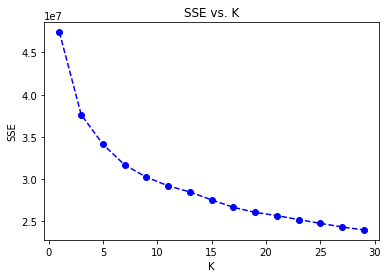

In [73]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=23)
model = kmeans.fit(azdias_pca)
azdias_clustered = model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

After analyzing the cluster data via KMeans and plotting the data, it appears there is not much difference in the data after 23 clusters. Therefore, 23 clusters were chosen to fit the model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [75]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [76]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customer_clean = clean_data(customers)
customer_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141725 entries, 0 to 191651
Data columns (total 65 columns):
ALTERSKATEGORIE_GROB     141492 non-null float64
ANREDE_KZ                141725 non-null int64
FINANZ_MINIMALIST        141725 non-null int64
FINANZ_SPARER            141725 non-null int64
FINANZ_VORSORGER         141725 non-null int64
FINANZ_ANLEGER           141725 non-null int64
FINANZ_UNAUFFAELLIGER    141725 non-null int64
FINANZ_HAUSBAUER         141725 non-null int64
GREEN_AVANTGARDE         141725 non-null int64
HEALTH_TYP               139386 non-null float64
RETOURTYP_BK_S           138601 non-null float64
SEMIO_SOZ                141725 non-null int64
SEMIO_FAM                141725 non-null int64
SEMIO_REL                141725 non-null int64
SEMIO_MAT                141725 non-null int64
SEMIO_VERT               141725 non-null int64
SEMIO_LUST               141725 non-null int64
SEMIO_ERL                141725 non-null int64
SEMIO_KULT               141725 non-n

In [77]:
#Perform imputer
clean_customers = imp.transform(customer_clean)

In [78]:
#Verifying no null vals
np.isnan(clean_customers).any()

False

In [79]:
#Applying standerdScaler to df
customer_scaled = scaler.transform(clean_customers)

In [80]:
#Converting to df
scaled_customers = pd.DataFrame(customer_scaled, columns=customer_clean.columns)

In [81]:
#Applying PCA 
customer_pca = pca.transform(customer_scaled)

In [82]:
# Cluster predictions for customer data 
customers_clustered = model.predict(customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

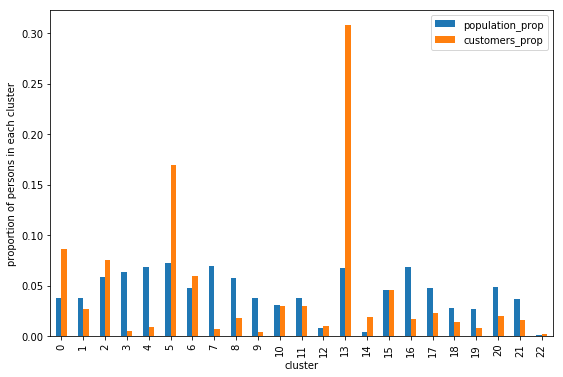

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_prop = []
customers_prop = []
x = [i for i in range(23)]
for i in range(23):
    population_prop.append((azdias_clustered == i).sum()/len(azdias_clustered))
    customers_prop.append((customers_clustered == i).sum()/len(customers_clustered))


df_general = pd.DataFrame({'cluster' : x, 'population_prop' : population_prop, 'customers_prop':customers_prop})

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_general.plot(x='cluster', y = ['population_prop', 'customers_prop'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()


Clusters that are significantly overrepresented: 0, 5, 13
    
Clusters that are significantly underrepresented: 3, 4, 7

In [84]:
#Function to compare clusters with customer dataset
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
pca_fit.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh', color='blue');

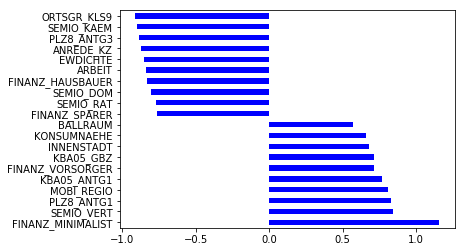

In [87]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plot_scaled_comparison(scaled_customers, model, 5)

Cluster 5 was most significantly overrepresented. Customers in this cluster tend to have a combative attitude and live in a small size of community. They tend to demonstrate high financial interest.

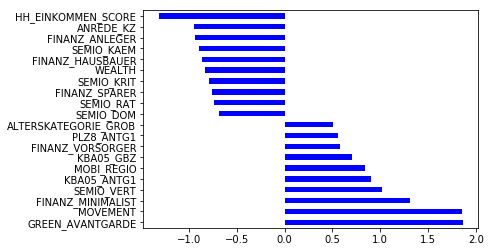

In [88]:
plot_scaled_comparison(scaled_customers, model, 13)

Cluster 13 was most significantly overrepresented. Customers in this cluster tend to be male, high estimated household income, investors with high financial interest. They tend not to be interested in environmental sustainability.

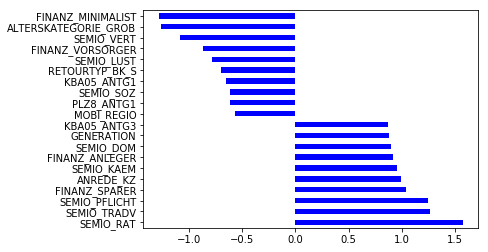

In [89]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

plot_scaled_comparison(scaled_customers, model, 3)

Cluster 3 was most significantly underrepresented. Customers in cluster 3 tend to demonstrate low financial interest, between 20-30 years of age, are dreamful, and tend not to be traditionally minded or rational. 

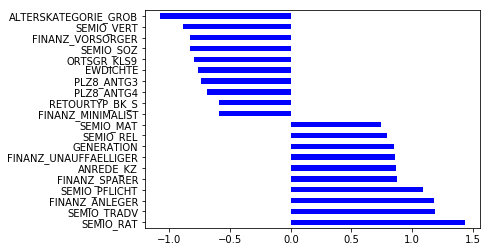

In [90]:
plot_scaled_comparison(scaled_customers, model, 4)

Cluster 4 was also identified as being significantly underrepresented. Customers in cluster 4 mirror those identified in cluster 3, with the addition of these customers preferring to be financially prepared but are not investors.

### Discussion 3.3: Compare Customer Data to Demographics Data

Segments of the population that would be popular with the mail-order company tend to be male investors with high financial interest from high estimated household incomes. They tend to have a combative attitude and are not typically  interested in environmental sustainability.

Segments of the population that may not be popular with the mail-order company demonstrate tend to be dreamful, with age range under 30, and demonstrate low financial interest. They tend not to be traditionally minded or rational. While they typically prefer to be financially prepared, they are not investors.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.